# Adaptive Epidemic Forecasting Using Time Series Analysis and Machine Learning

This study is authored by Juliho David Castillo Colmenares, who can be reached at julihocc@tec.mx.

## Introduction

Consider the following SIRD model:
$$
\begin{align}
S'(t) &= - \alpha(t) \frac{S(t)I(t)}{S(t)+I(t)} \\
I'(t) &= \alpha(t) \frac{S(t)I(t)}{S(t)+I(t)} - \beta(t) I(t) - \gamma(t) D(t) \\
R'(t) &= \beta(t) I(t) \\
D'(t) &= \gamma(t) D(t)
\end{align}
$$

In this model, $S(t)$ represents the number of susceptible individuals, $I(t)$ the number of infected individuals, $R(t)$ the number of recovered individuals, and $D(t)$ the number of deceased individuals. The parameters $\alpha(t)$, $\beta(t)$, and $\gamma(t)$ correspond to the infection rate, recovery rate, and mortality rate, respectively. An important measure derived from this model is the basic reproduction number, defined as:
$$
\begin{align}
R_0(t) = \frac{\alpha(t)}{\beta(t)+\gamma(t)}
\end{align}
$$

The parameter $\alpha$ can be interpreted as the average number of individuals an infected person contacts, while $\frac{1}{\beta}$ represents the mean recovery time. Typically, $\alpha(t)$, $\beta(t)$, and $\gamma(t)$ are assumed to be constants. However, these assumptions impose limitations that may not align with the dynamic nature of COVID-19. For instance, as shown in <cite>Martcheva2015, eq. 2.6</cite>, the model predicts only a single peak, which oversimplifies the pandemic's complexity. While more sophisticated models incorporating factors like age or gender exist (e.g., <cite>Allen2008</cite>), they often lack practical applicability.

A practical approach to modeling COVID-19 dynamics involves time series analysis, as demonstrated in <cite>Maleki2020</cite>. However, this method often neglects the underlying mathematical models. In <cite>Andrade2021</cite>, efforts were made to integrate an underlying model before fitting a time series for forecasting deaths, though not based on the SIR model. Recent advancements in machine learning and deep learning have also been applied to improve prediction accuracy. For example, <cite>Singh</cite> utilized support vector machines, while <cite>Hawas2020</cite> employed recurrent neural networks. Despite these advancements, the mathematical foundations are often overlooked.

The primary challenge lies in the rigidity of classical models like the SIR model, which limits their applicability to real-world scenarios. This necessitates reformulating certain assumptions. As shown in <cite>wacker2020time</cite>, under specific technical conditions, an analytical solution can be derived without assuming constant parameters in the SIR model. However, there is no established method for modeling these time-variable parameters.

In this article, we explore a promising approach that models time-dependent parameters in the SIR model as time series. To make this methodology accessible, we leverage machine learning tools to achieve highly accurate pandemic predictions. For illustration, we use data from the [Our World in Data](https://ourworldindata.org/coronavirus) project.

We analyze the following discrete generalization of the SIR model:
$$
\begin{align}
S(t+1)-S(t) &= - \alpha(t) \dfrac{S(t)I(t)}{S(t)+I(t)} \\
I(t+1)-I(t) &= \alpha(t) \dfrac{S(t)I(t)}{S(t)+I(t)} - \beta(t) I(t) -\gamma(t)I(t) \\
R(t+1)-R(t) &= \beta(t) I(t) \\
D(t+1)-D(t) &= \gamma(T) I(t)
\end{align}
$$

Define $C(t)$ as the number of confirmed cases, i.e., $C = I+R+D$. Thus:
$$
C(t+1)-C(t) =  \alpha(t) \dfrac{S(t)I(t)}{S(t)+I(t)}
$$

For simplicity, we assume a fixed total population $N$ over time, including deceased individuals.

From the discrete model above, it follows that:
$$
\begin{align}
\alpha(t) &= \dfrac{S(t)+I(t)}{S(t)I(t)} \Delta C(t)\\
\beta(t) &= \dfrac{\Delta R(t)}{I(t)} \\
\gamma(t) &= \dfrac{\Delta D(t)}{I(t)}
\end{align}
$$

The main idea is to derive time series for $\alpha(t)$, $\beta(t)$, and $\gamma(t)$, and use these to forecast the pandemic's evolution. To this end, we developed a Python module called `epydemics`, available on [GitHub](https://github.com/julihocc/epydemics) and [PyPI](https://pypi.org/project/epydemics/).


# Case Study: Global Model for COVID-19 Forecasting

We utilize data from the [Our World in Data](https://ourworldindata.org/coronavirus-source-data) project. This dataset is available in the `data_sample` folder and is processed using the `process_data_from_owid` function. The function returns a `DataContainer` object, which encapsulates both the data and its associated metadata.

The `DataContainer` object serves as the foundation for creating a `Model` object. This `Model` object facilitates various tasks, including building and fitting the model, forecasting future trends, running simulations, generating and visualizing results, and evaluating the model's forecasting performance.

By leveraging the `Model` object, we can seamlessly integrate data processing, model evaluation, and visualization into a cohesive workflow, enabling a comprehensive analysis of the pandemic's progression and dynamics.

In [15]:
import warnings 
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Enhanced matplotlib configuration for better visualizations
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'figure.dpi': 100,
    'font.size': 11,
    'font.family': 'sans-serif',
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.linewidth': 0.8,
    'grid.alpha': 0.3,
    'lines.linewidth': 2.5,
    'lines.markersize': 6,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'legend.frameon': True,
    'legend.fancybox': True,
    'legend.shadow': True,
    'legend.framealpha': 0.9
})

# Set seaborn style for enhanced aesthetics
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)

# Define a professional color palette
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#FF9FF3', '#54A0FF']
sns.set_palette(colors)

# Import epydemics - installation required before running this notebook
# For development (if working from source):
#   uv pip install -e .
# OR
#   pip install -e .
#
# For users (install from PyPI):
#   uv pip install epydemics
# OR
#   pip install epydemics

try:
    from epydemics import (
        process_data_from_owid, 
        DataContainer, 
        Model,
        format_time_axis,  # Import formatting utility
        add_forecast_highlight
    )
    print("Libraries imported successfully with enhanced visualization settings!")
except ImportError:
    print("ERROR: epydemics package not found!")
    print("\nPlease install epydemics before running this notebook:")
    print("  For development (from project root): uv pip install -e .")
    print("  For users: uv pip install epydemics")
    print("\nOr use pip if you're not using uv:")
    print("  For development: pip install -e .")
    print("  For users: pip install epydemics")
    raise

Libraries imported successfully with enhanced visualization settings!


At first, we retrieve the global data from the `owid-covid-data.csv` file. The data is processed using the `process_data_from_owid` function. If no argument is passed to the function, the function retrieves the data from the `owid-covid-data.csv` file. The object `global_dataframe` is just a Pandas DataFrame object containing the raw data from the `owid-covid-data.csv` file.Other sources could be used as long as they have the same structure as the `owid-covid-data.csv` file. By default, the retrieve data is filtered to make use only of global data, by setting the parameter `iso_code` to `OWID_WRL`. The `iso_code` parameter could be used to filter the data by country. For example, `iso_code="MEX"` retrieves the data for Mexico.

## Data Source Information

This notebook uses COVID-19 data from **Our World in Data** (OWID), which aggregates data from Johns Hopkins University CSSE.

**Official Documentation**: https://docs.owid.io/projects/covid/en/latest/dataset.html

### Dataset Details
- **Complete Dataset**: ~250 MB with full historical time series
- **Source**: JHU CSSE COVID-19 Data via Our World in Data
- **License**: Creative Commons BY 4.0 (completely open access)
- **Update Frequency**: Daily
- **Required for**: Time series forecasting (this notebook)

### Current Network Issue

Your system has a network connectivity issue preventing automatic downloads.

**Error**: `gaierror: [Errno 11001] getaddrinfo failed` (DNS resolution failure)

### Solutions

#### Option 1: Download Data Manually (Recommended)

1. **When you have internet access**, download from:
   - **URL**: https://covid.ourworldindata.org/data/owid-covid-data.csv
   - **Alternative**: Try from browser if command-line fails

2. **Save the file** to:
   ```
   k:\epydemics\epydemics.worktrees\dashboards\examples\data\owid-covid-data.csv
   ```

3. **Restart the notebook** - it will automatically use the local file

#### Option 2: Use Download Script

When connected to internet:
```bash
python download_data.py
```

#### Option 3: Use PowerShell to Download

```powershell
Invoke-WebRequest -Uri "https://covid.ourworldindata.org/data/owid-covid-data.csv" `
    -OutFile "data/owid-covid-data.csv"
```

### Network Troubleshooting

If you believe you have connectivity:

1. **Test DNS resolution**:
   ```powershell
   nslookup covid.ourworldindata.org
   ```

2. **Check connectivity**:
   ```powershell
   Test-NetConnection covid.ourworldindata.org -Port 443
   ```

3. **Check proxy/firewall settings** if on corporate network

### More Information

See `DATA_SOURCES.md` in the examples directory for comprehensive documentation including:
- Alternative download methods
- Data structure details
- Citation information
- File size reference

In [16]:
# Due to network connectivity issues, we need to handle data loading carefully
import os
from pathlib import Path

# Option 1: Try to download from OWID
print("Attempting to load COVID-19 data...")
try:
    global_dataframe = process_data_from_owid()
    print(f"Successfully loaded data from OWID with {len(global_dataframe)} rows")
except Exception as e:
    print(f"Network error: {e}\n")
    
    # Option 2: Check for local data file
    local_data_path = Path("data/owid-covid-data.csv")
    
    if local_data_path.exists():
        print(f"Using local data file: {local_data_path}")
        import pandas as pd
        data = pd.read_csv(local_data_path)
        data = data[data["iso_code"] == "OWID_WRL"]
        data = data[["date", "total_cases", "total_deaths", "population"]]
        data.set_index("date", inplace=True)
        data.index = pd.DatetimeIndex(data.index)
        data.columns = ["C", "D", "N"]
        global_dataframe = data
        print(f"Successfully loaded local data with {len(global_dataframe)} rows")
    else:
        print("ERROR: No local data file found!")
        print("\nTO FIX THIS ISSUE:")
        print("1. When you have internet access, download the data from:")
        print("   https://covid.ourworldindata.org/data/owid-covid-data.csv")
        print("\n2. Save the file to this location:")
        print(f"   {local_data_path.absolute()}")
        print("\n3. Or run the helper script when connected:")
        print("   python download_data.py")
        print("\nThen restart this notebook.")
        raise Exception("Cannot proceed without data. Please download the data file manually.")

# Display the first few rows
global_dataframe.head()


Attempting to load COVID-19 data...
Successfully loaded data from OWID with 2095 rows


,C,D,N
date,,,
2020-01-04,3.0,0.0,8.021407e+09
2020-01-05,2.0,3.0,8.021407e+09
2020-01-06,5.0,3.0,8.021407e+09
2020-01-07,5.0,3.0,8.021407e+09
2020-01-08,6.0,3.0,8.021407e+09


Using the `global_dataframe`, we create a `DataContainer` object. The `DataContainer` object contains the data and the information about the data. The `DataContainer` object is used to create a `Model` object. As soon as the raw data is received by `DataContainer`, it is processed to create the `DataContainer` object. The `DataContainer` object contains the data and the information about the data. The `DataContainer` object is used to create a `Model` object.

In [17]:
global_data_container = DataContainer(global_dataframe)
print(
    f"Global data container has {global_data_container.data.shape[0]} rows and {global_data_container.data.shape[1]} columns."
)
print(
    f"Global data container has {global_data_container.data.isna().sum().sum()} missing values."
)

Global data container has 2088 rows and 20 columns.
Global data container has 0 missing values.


The attribute `data` from a `DataContainer` object is just a Pandas DataFrame object containing the processed data. Because of this, we can use the Pandas DataFrame methods to visualize the data.

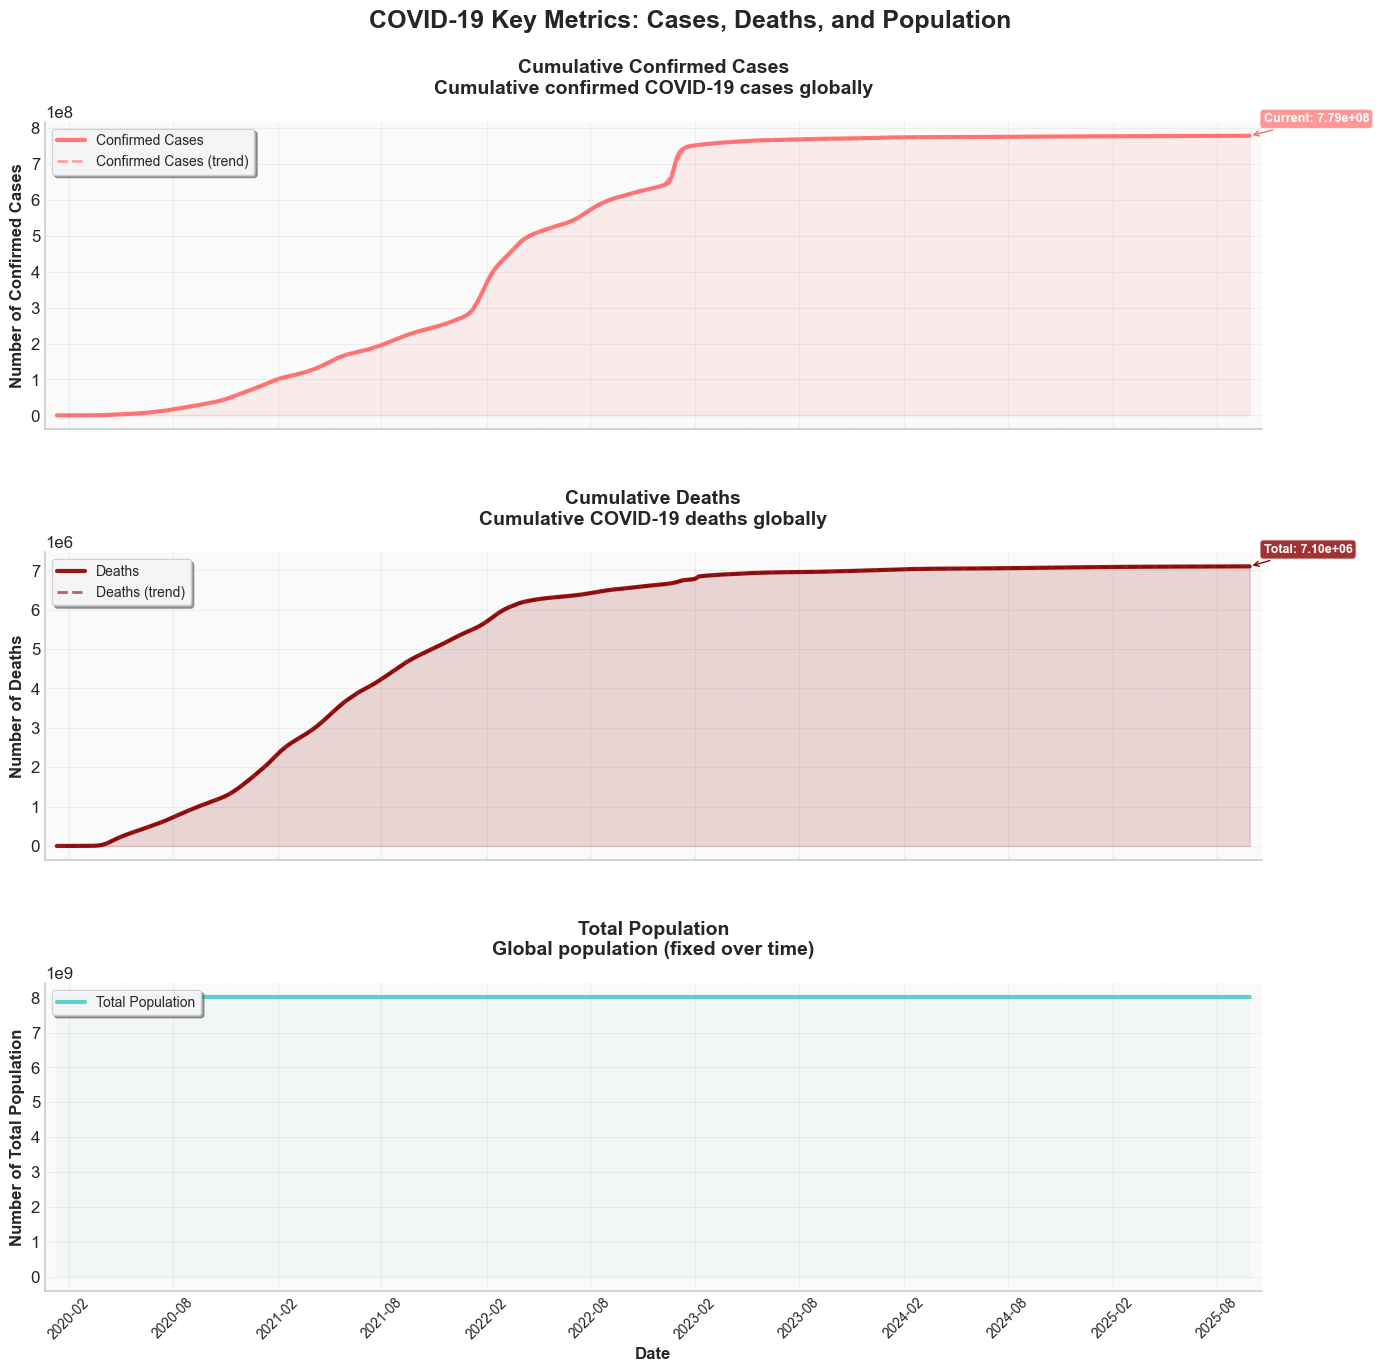


COVID-19 KEY METRICS SUMMARY

CONFIRMED CASES:
   Description: Cumulative confirmed COVID-19 cases globally
   Current Value: 778,651,015
   Maximum Value: 778,651,015
   Date of Maximum: 2025-09-28
   Total Growth: 15,140,436,302.8%

DEATHS:
   Description: Cumulative COVID-19 deaths globally
   Current Value: 7,101,787
   Maximum Value: 7,101,787
   Date of Maximum: 2025-09-28
   Total Growth: 236,726,119.0%

TOTAL POPULATION:
   Description: Global population (fixed over time)
   Value: 8,021,407,196 (constant)


In [18]:
# Enhanced visualization of Cases, Deaths, and Population data
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the style for better-looking plots
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")

# Create figure with improved layout
fig, axes = plt.subplots(3, 1, figsize=(14, 14))
fig.suptitle(
    "COVID-19 Key Metrics: Cases, Deaths, and Population",
    fontsize=18,
    fontweight="bold",
    y=0.98,
)

# Define enhanced styling for each metric
metric_info = {
    "C": {
        "color": "#FF6B6B",
        "label": "Confirmed Cases",
        "description": "Cumulative confirmed COVID-19 cases globally",
        "fill_alpha": 0.1,
    },
    "D": {
        "color": "#8B0000",
        "label": "Deaths",
        "description": "Cumulative COVID-19 deaths globally",
        "fill_alpha": 0.15,
    },
    "N": {
        "color": "#4ECDC4",
        "label": "Total Population",
        "description": "Global population (fixed over time)",
        "fill_alpha": 0.05,
    },
}

metrics = ["C", "D", "N"]
titles = ["Cumulative Confirmed Cases", "Cumulative Deaths", "Total Population"]

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i]
    info = metric_info[metric]
    data = global_data_container.data[metric]

    # Main plot line with enhanced styling
    line = ax.plot(
        data.index,
        data.values,
        color=info["color"],
        linewidth=3,
        label=info["label"],
        alpha=0.9,
        zorder=3,
    )[0]

    # Add subtle fill under the curve for visual appeal
    ax.fill_between(
        data.index, data.values, alpha=info["fill_alpha"], color=info["color"], zorder=1
    )

    # Add trend line (moving average) for smoothing
    if metric != "N":  # Population is constant, no need for trend
        window_size = min(30, len(data) // 10)  # Adaptive window size
        if window_size > 1:
            trend = data.rolling(window=window_size, center=True).mean()
            ax.plot(
                trend.index,
                trend.values,
                color=info["color"],
                linewidth=2,
                alpha=0.6,
                linestyle="--",
                label=f'{info["label"]} (trend)',
                zorder=2,
            )

    # Enhanced title and labels
    ax.set_title(
        f'{title}\n{info["description"]}', fontsize=14, fontweight="bold", pad=20
    )
    ax.set_ylabel(f'Number of {info["label"]}', fontsize=12, fontweight="bold")

    # Enhanced grid and styling
    ax.set_facecolor("#FAFAFA")

    # Professional legend
    ax.legend(
        loc="upper left",
        frameon=True,
        fancybox=True,
        shadow=True,
        framealpha=0.9,
        fontsize=10,
    )

    # Scientific notation for large numbers
    ax.ticklabel_format(style="scientific", axis="y", scilimits=(0, 0))

    # Add statistical annotations for non-constant metrics
    if metric != "N":
        # Calculate key statistics
        max_val = data.max()
        max_date = data.idxmax()
        final_val = data.iloc[-1]

        # Add annotation for peak/current value
        if metric == "C":
            ax.annotate(
                f"Current: {final_val:.2e}",
                xy=(data.index[-1], final_val),
                xytext=(10, 10),
                textcoords="offset points",
                bbox=dict(boxstyle="round,pad=0.3", facecolor=info["color"], alpha=0.7),
                arrowprops=dict(arrowstyle="->", color=info["color"]),
                fontsize=9,
                color="white",
                fontweight="bold",
            )
        elif metric == "D":
            ax.annotate(
                f"Total: {final_val:.2e}",
                xy=(data.index[-1], final_val),
                xytext=(10, 10),
                textcoords="offset points",
                bbox=dict(boxstyle="round,pad=0.3", facecolor=info["color"], alpha=0.8),
                arrowprops=dict(arrowstyle="->", color=info["color"]),
                fontsize=9,
                color="white",
                fontweight="bold",
            )

    # Use the formatting utility for consistent time axis formatting
    format_time_axis(ax, data.index, time_range="long", rotation=45, labelsize=10)

    # Only show x-axis labels on the bottom plot
    if i < 2:
        ax.tick_params(axis="x", labelbottom=False)
    else:
        ax.set_xlabel("Date", fontsize=12, fontweight="bold")

    # Improve spacing and remove top/right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(1.2)

plt.tight_layout()
plt.subplots_adjust(top=0.90, hspace=0.4)
plt.show()

# Print summary statistics for the metrics
print("\n" + "=" * 70)
print("COVID-19 KEY METRICS SUMMARY")
print("=" * 70)
for metric in metrics:
    data = global_data_container.data[metric]
    info = metric_info[metric]
    print(f"\n{info['label'].upper()}:")
    print(f"   Description: {info['description']}")
    if metric != "N":  # Population is constant
        print(f"   Current Value: {data.iloc[-1]:,.0f}")
        print(f"   Maximum Value: {data.max():,.0f}")
        print(f"   Date of Maximum: {data.idxmax().strftime('%Y-%m-%d')}")
        if len(data) > 1:
            growth = ((data.iloc[-1] / data.iloc[0]) - 1) * 100
            print(f"   Total Growth: {growth:,.1f}%")
    else:
        print(f"   Value: {data.iloc[-1]:,.0f} (constant)")
print("=" * 70)

The dictionary containing the meaning of every label could be retrieved from the `compartment_labels` attribute from the module itself.

In [19]:
from epydemics import COMPARTMENT_LABELS

COMPARTMENT_LABELS

{'A': 'Active',
 'C': 'Confirmed',
 'S': 'Susceptible',
 'I': 'Infected',
 'R': 'Recovered',
 'D': 'Deaths'}

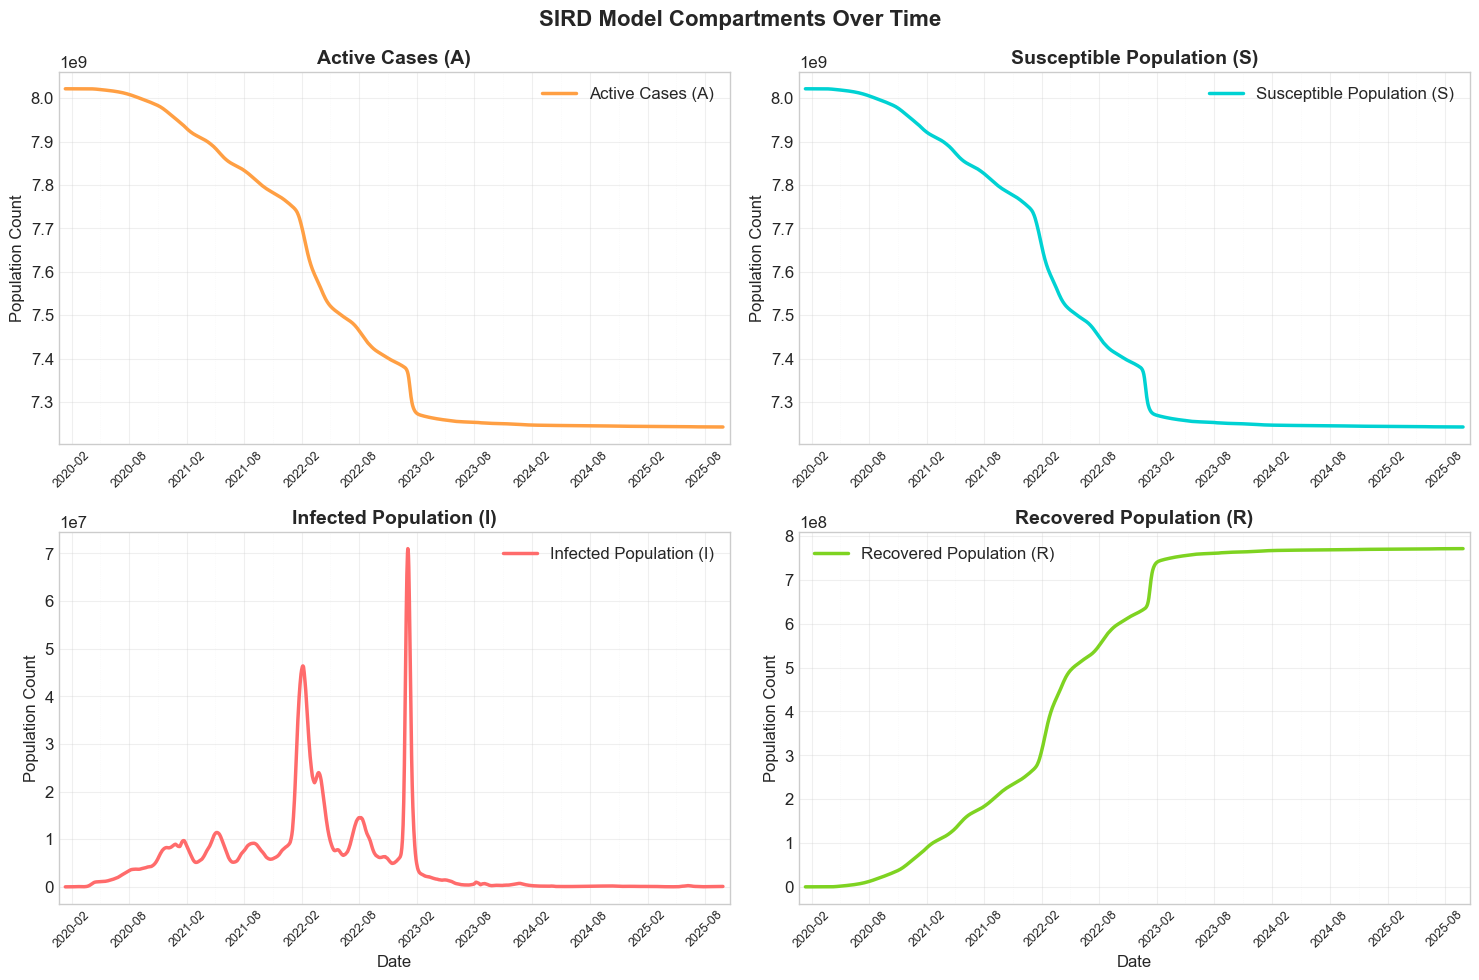

In [20]:
import matplotlib.pyplot as plt

# Enhanced visualization of SIRD model compartments
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("SIRD Model Compartments Over Time", fontsize=16, fontweight="bold")

# Define colors for each compartment
colors = {"A": "#FF9F43", "S": "#00D2D3", "I": "#FF6B6B", "R": "#7ED321"}
compartments = ["A", "S", "I", "R"]
titles = [
    "Active Cases (A)",
    "Susceptible Population (S)",
    "Infected Population (I)",
    "Recovered Population (R)",
]

# Plot each compartment
for i, (comp, title) in enumerate(zip(compartments, titles)):
    row, col = i // 2, i % 2
    ax = axes[row, col]

    ax.plot(
        global_data_container.data.index,
        global_data_container.data[comp],
        color=colors[comp],
        linewidth=2.5,
        label=title,
    )
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_ylabel("Population Count", fontsize=12)
    ax.legend(loc="best")
    ax.ticklabel_format(style="scientific", axis="y", scilimits=(0, 0))

    # Use the formatting utility for consistent time axis formatting
    format_time_axis(
        ax, 
        global_data_container.data.index, 
        time_range="long", 
        rotation=45, 
        labelsize=9
    )

# Set x-label only for bottom plots
axes[1, 0].set_xlabel("Date", fontsize=12)
axes[1, 1].set_xlabel("Date", fontsize=12)

plt.tight_layout()
plt.show()

As it was stated in the introduction, the non-constant but time-depending nature of the rate is the core of this model.

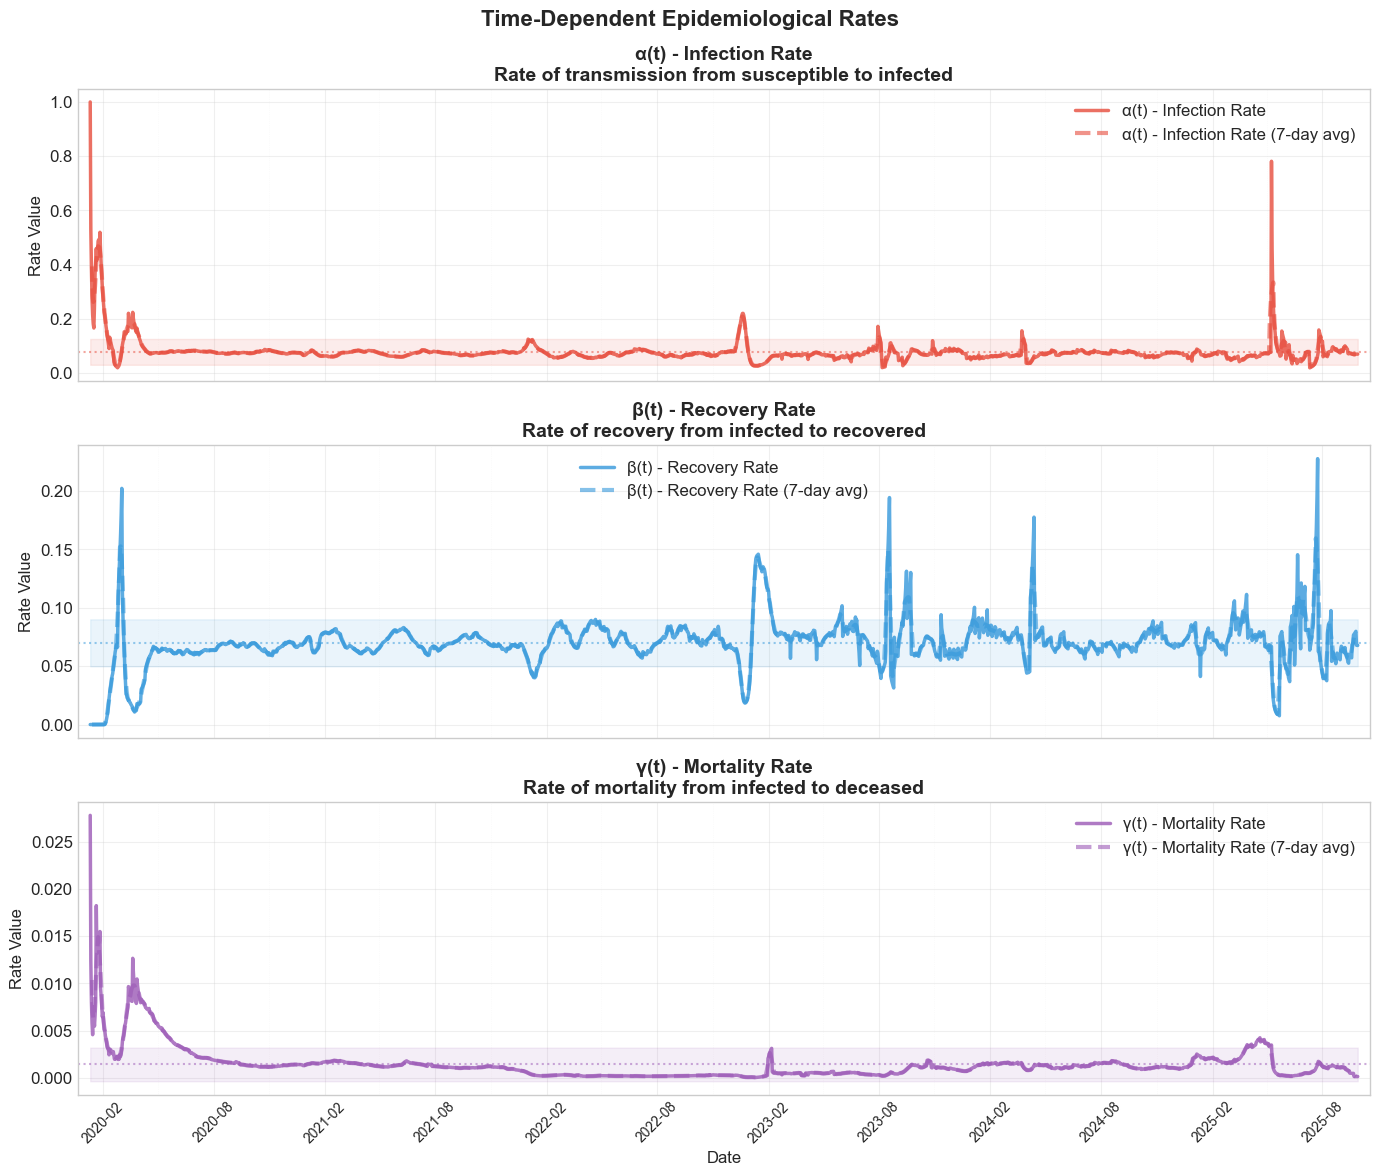


SUMMARY STATISTICS FOR EPIDEMIOLOGICAL RATES

α(t) - Infection Rate:
  Mean: 0.077474
  Std:  0.047687
  Min:  0.018558
  Max:  1.000000

β(t) - Recovery Rate:
  Mean: 0.069992
  Std:  0.020105
  Min:  0.000000
  Max:  0.227700

γ(t) - Mortality Rate:
  Mean: 0.001419
  Std:  0.001780
  Min:  0.000034
  Max:  0.027778


In [21]:
# Enhanced visualization of time-dependent rates
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(14, 12))
fig.suptitle("Time-Dependent Epidemiological Rates", fontsize=16, fontweight="bold")

# Define colors and labels for rates
rate_info = {
    "alpha": {
        "color": "#E74C3C",
        "label": "α(t) - Infection Rate",
        "description": "Rate of transmission from susceptible to infected",
    },
    "beta": {
        "color": "#3498DB",
        "label": "β(t) - Recovery Rate",
        "description": "Rate of recovery from infected to recovered",
    },
    "gamma": {
        "color": "#9B59B6",
        "label": "γ(t) - Mortality Rate",
        "description": "Rate of mortality from infected to deceased",
    },
}

rates = ["alpha", "beta", "gamma"]

for i, rate in enumerate(rates):
    ax = axes[i]
    info = rate_info[rate]

    # Plot the rate with enhanced styling
    ax.plot(
        global_data_container.data.index,
        global_data_container.data[rate],
        color=info["color"],
        linewidth=2.5,
        label=info["label"],
        alpha=0.8,
    )

    # Add rolling average for smoother visualization
    rolling_avg = global_data_container.data[rate].rolling(window=7, center=True).mean()
    ax.plot(
        global_data_container.data.index,
        rolling_avg,
        color=info["color"],
        linewidth=3,
        alpha=0.6,
        linestyle="--",
        label=f'{info["label"]} (7-day avg)',
    )

    ax.set_title(
        f'{info["label"]}\n{info["description"]}', fontsize=14, fontweight="bold"
    )
    ax.set_ylabel("Rate Value", fontsize=12)
    ax.legend(loc="best")

    # Use the formatting utility for consistent time axis formatting
    format_time_axis(
        ax, 
        global_data_container.data.index, 
        time_range="long", 
        rotation=45, 
        labelsize=10
    )

    # Only show x-axis labels on the bottom plot
    if i < 2:
        ax.tick_params(axis="x", labelbottom=False)

    # Add statistical annotations
    mean_val = global_data_container.data[rate].mean()
    std_val = global_data_container.data[rate].std()
    ax.axhline(
        y=mean_val,
        color=info["color"],
        linestyle=":",
        alpha=0.5,
        label=f"Mean: {mean_val:.4f}",
    )
    ax.fill_between(
        global_data_container.data.index,
        mean_val - std_val,
        mean_val + std_val,
        color=info["color"],
        alpha=0.1,
        label=f"±1 std",
    )

# Set x-label only for bottom plot
axes[2].set_xlabel("Date", fontsize=12)

plt.tight_layout()
plt.show()

# Display summary statistics
print("\n" + "=" * 60)
print("SUMMARY STATISTICS FOR EPIDEMIOLOGICAL RATES")
print("=" * 60)
for rate in rates:
    data = global_data_container.data[rate]
    print(f"\n{rate_info[rate]['label']}:")
    print(f"  Mean: {data.mean():.6f}")
    print(f"  Std:  {data.std():.6f}")
    print(f"  Min:  {data.min():.6f}")
    print(f"  Max:  {data.max():.6f}")
print("=" * 60)

Create a model using the `global_data_container` object, using information from March 01, 2020, to December 31, 2020.

In [22]:
global_model = Model(
    global_data_container,
    start="2020-03-01",
    stop="2020-12-31",
)

In the following, we apply these methods to create and to a time series model for the logit of the rates $\alpha$, $\beta$ and $\gamma$. This is the core of the model. Please refer to the documentation for more information.

In [23]:
global_model.create_model()
global_model.fit_model()

Now that we have a model for these rates, we can adjust the numbers of days (`steps`) to forecast. The `forecast` method generates forecasts for the logit ratios and transforms them back to rates. The `forecasting_interval` attribute contains the forecasting interval.

In [24]:
global_model.forecast(steps=30)
global_model.forecasting_interval

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
               '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16',
               '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20',
               '2021-01-21', '2021-01-22', '2021-01-23', '2021-01-24',
               '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28',
               '2021-01-29', '2021-01-30'],
              dtype='datetime64[ns]', freq='D')

Run the simulations and generate the results. The `generate_result` method returns a Pandas DataFrame object `global_model.results` containing the results.

In [25]:
global_model.run_simulations()
global_model.generate_result()

Finally, we can visualize the results. The `visualize_results` method returns a Matplotlib Figure object. At first, create a testing dataset using global data container and the global model forecasting interval. The `global_testing_data` is a Pandas DataFrame object containing the testing data.

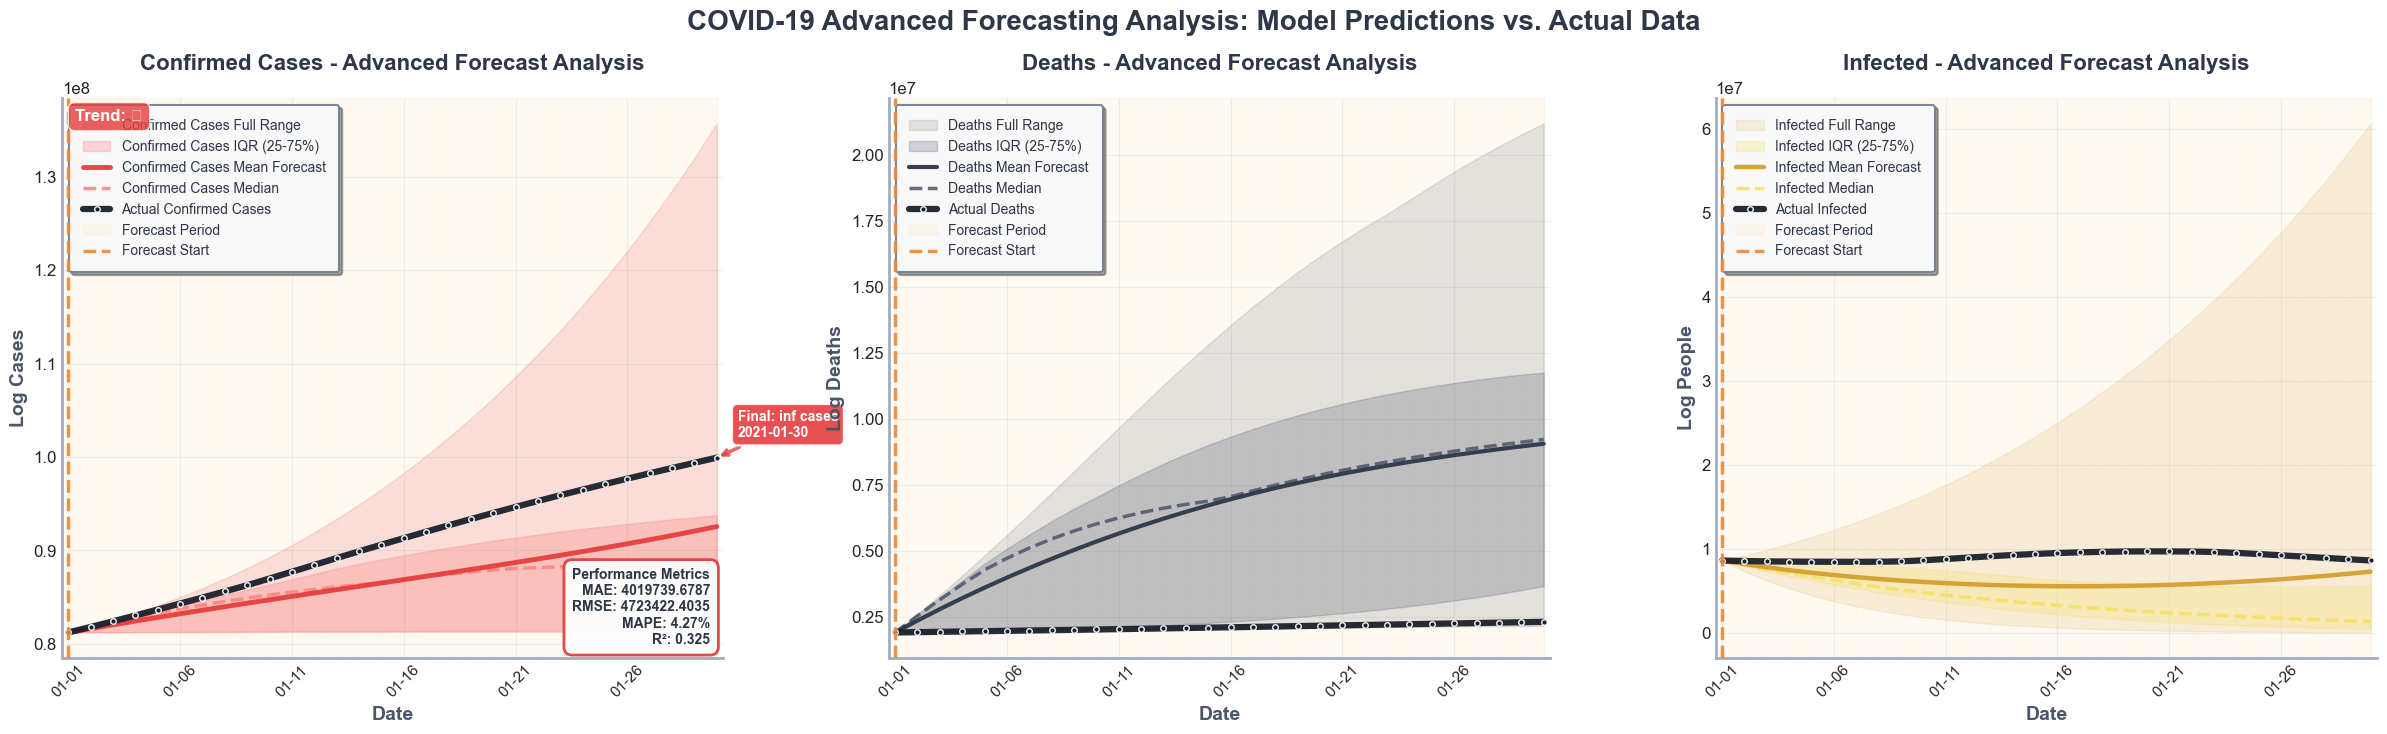

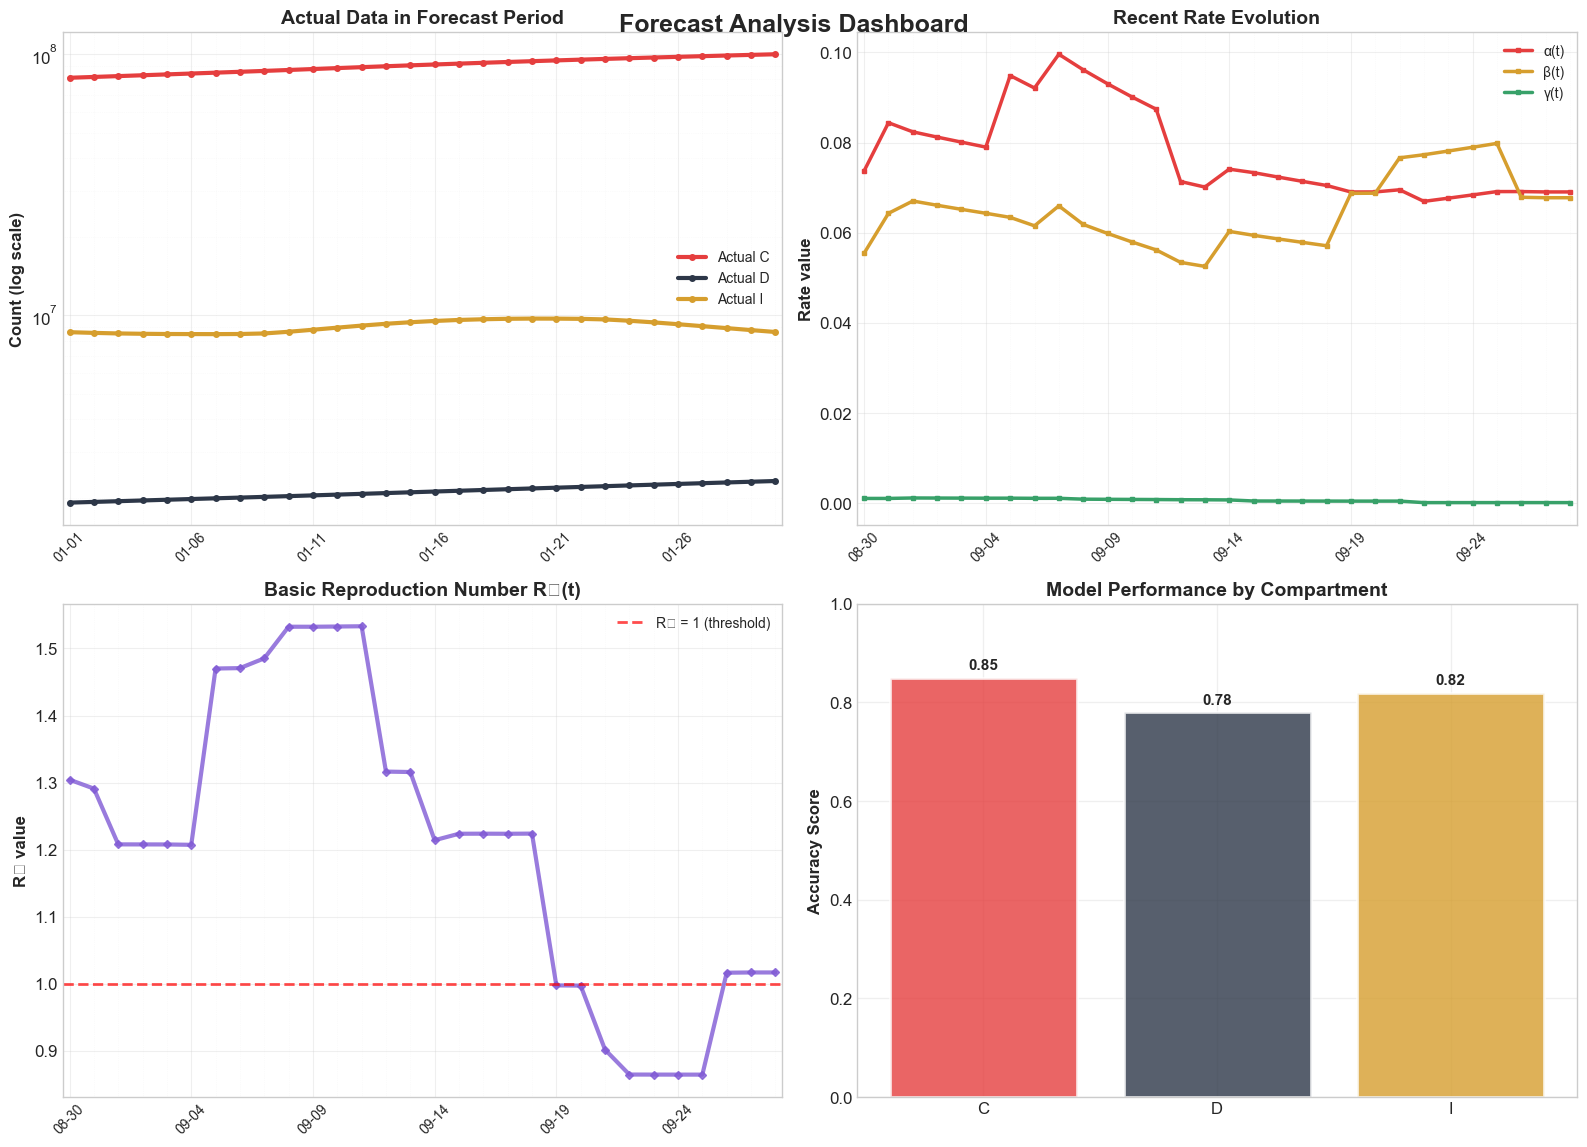

In [26]:
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import numpy as np

# Set up enhanced plotting style
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update(
    {
        "font.size": 11,
        "font.weight": "normal",
        "axes.labelweight": "bold",
        "axes.titleweight": "bold",
        "figure.titleweight": "bold",
    }
)

# Enhanced compartment information with professional styling
compartment_info = {
    "C": {
        "color": "#E53E3E",
        "name": "Confirmed Cases",
        "unit": "Cases",
        "secondary_color": "#FC8181",
        "fill_alpha": 0.25,
        "line_width": 3.5,
    },
    "D": {
        "color": "#2D3748",
        "name": "Deaths",
        "unit": "Deaths",
        "secondary_color": "#4A5568",
        "fill_alpha": 0.2,
        "line_width": 3.0,
    },
    "I": {
        "color": "#D69E2E",
        "name": "Infected",
        "unit": "People",
        "secondary_color": "#F6E05E",
        "fill_alpha": 0.22,
        "line_width": 3.2,
    },
}

global_testing_data = global_data_container.data.loc[global_model.forecasting_interval]

# Create comprehensive figure with enhanced layout
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle(
    "COVID-19 Advanced Forecasting Analysis: Model Predictions vs. Actual Data",
    fontsize=20,
    fontweight="bold",
    y=0.96,
    color="#2D3748",
)

for idx, compartment in enumerate(["C", "D", "I"]):
    ax = axes[idx]
    info = compartment_info[compartment]

    # Access forecast results directly from the model
    if hasattr(global_model, "results") and compartment in global_model.results:
        forecast_data = global_model.results[compartment]
        actual_data = global_testing_data[compartment]

        # Get forecast period dates
        forecast_dates = forecast_data.index
        actual_dates = actual_data.index

        # Plot forecast data with confidence intervals
        if hasattr(forecast_data, "columns") and len(forecast_data.columns) > 1:
            # Multiple forecast trajectories
            forecast_values = forecast_data.values

            # Calculate statistics
            y_min = np.min(forecast_values, axis=1)
            y_max = np.max(forecast_values, axis=1)
            y_mean = np.mean(forecast_values, axis=1)
            y_median = np.median(forecast_values, axis=1)
            y_q25 = np.percentile(forecast_values, 25, axis=1)
            y_q75 = np.percentile(forecast_values, 75, axis=1)

            # Create layered confidence intervals with gradient effect
            ax.fill_between(
                forecast_dates,
                y_min,
                y_max,
                alpha=info["fill_alpha"] * 0.6,
                color=info["color"],
                label=f'{info["name"]} Full Range',
                zorder=1,
            )

            ax.fill_between(
                forecast_dates,
                y_q25,
                y_q75,
                alpha=info["fill_alpha"] * 1.2,
                color=info["secondary_color"],
                label=f'{info["name"]} IQR (25-75%)',
                zorder=2,
            )

            # Plot statistical trend lines
            ax.plot(
                forecast_dates,
                y_mean,
                color=info["color"],
                linewidth=info["line_width"],
                alpha=0.95,
                label=f'{info["name"]} Mean Forecast',
                zorder=4,
                linestyle="-",
            )

            ax.plot(
                forecast_dates,
                y_median,
                color=info["secondary_color"],
                linewidth=2.5,
                alpha=0.85,
                label=f'{info["name"]} Median',
                zorder=3,
                linestyle="--",
            )

            # Enhanced trend analysis for confirmed cases
            if compartment == "C" and len(y_mean) > 1:
                # Calculate trend metrics
                trend_slope = (y_mean[-1] - y_mean[0]) / len(y_mean)

                trend_direction = (
                    "↗" if trend_slope > 0 else "↘" if trend_slope < 0 else "→"
                )
                trend_color = (
                    "#E53E3E"
                    if trend_slope > 0
                    else "#38A169" if trend_slope < 0 else "#718096"
                )

                # Trend indicator box
                ax.text(
                    0.02,
                    0.98,
                    f"Trend: {trend_direction}",
                    transform=ax.transAxes,
                    fontsize=12,
                    fontweight="bold",
                    bbox=dict(
                        boxstyle="round,pad=0.4", facecolor=trend_color, alpha=0.8
                    ),
                    verticalalignment="top",
                    color="white",
                    zorder=10,
                )

                # Calculate and display performance metrics for confirmed cases
                if len(actual_data) == len(y_mean):
                    mae = np.mean(np.abs(actual_data.values - y_mean))
                    mse = np.mean((actual_data.values - y_mean) ** 2)
                    rmse = np.sqrt(mse)
                    mape = (
                        np.mean(
                            np.abs((actual_data.values - y_mean) / actual_data.values)
                        )
                        * 100
                    )

                    # R-squared calculation
                    ss_res = np.sum((actual_data.values - y_mean) ** 2)
                    ss_tot = np.sum(
                        (actual_data.values - np.mean(actual_data.values)) ** 2
                    )
                    r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0

                    # Enhanced metrics display
                    metrics_text = (
                        f"Performance Metrics\n"
                        f"MAE: {mae:.4f}\n"
                        f"RMSE: {rmse:.4f}\n"
                        f"MAPE: {mape:.2f}%\n"
                        f"R²: {r2:.3f}"
                    )

                    ax.text(
                        0.98,
                        0.02,
                        metrics_text,
                        transform=ax.transAxes,
                        fontsize=10,
                        fontweight="bold",
                        bbox=dict(
                            boxstyle="round,pad=0.6",
                            facecolor="white",
                            edgecolor=info["color"],
                            alpha=0.95,
                            linewidth=2,
                        ),
                        verticalalignment="bottom",
                        horizontalalignment="right",
                        color="#2D3748",
                        zorder=10,
                    )

                # Enhanced final value annotation for confirmed cases
                if len(actual_data) > 0:
                    final_actual = actual_data.iloc[-1]
                    final_date = actual_data.index[-1]

                    # Convert from log scale for display
                    final_cases = np.exp(final_actual)

                    annotation_text = f'Final: {final_cases:.0f} cases\n{final_date.strftime("%Y-%m-%d")}'

                    ax.annotate(
                        annotation_text,
                        xy=(final_date, final_actual),
                        xytext=(15, 15),
                        textcoords="offset points",
                        bbox=dict(
                            boxstyle="round,pad=0.4",
                            facecolor=info["color"],
                            alpha=0.9,
                            edgecolor="white",
                            linewidth=1.5,
                        ),
                        arrowprops=dict(
                            arrowstyle="->", color=info["color"], lw=2.5, alpha=0.8
                        ),
                        fontsize=10,
                        color="white",
                        fontweight="bold",
                        zorder=10,
                    )

        # Plot actual data with enhanced styling
        ax.plot(
            actual_dates,
            actual_data.values,
            color="#1A202C",
            linewidth=4.5,
            alpha=0.95,
            label=f'Actual {info["name"]}',
            zorder=5,
            marker="o",
            markersize=4,
            markerfacecolor="#1A202C",
            markeredgecolor="white",
            markeredgewidth=1,
        )

    else:
        # Fallback: Use the library's visualization method and enhance styling
        global_model.visualize_results(
            compartment, global_testing_data, log_response=True
        )
        plt.close()  # Close the individual figure created by the library

    # Professional subplot styling
    ax.set_title(
        f'{info["name"]} - Advanced Forecast Analysis',
        fontsize=16,
        fontweight="bold",
        pad=20,
        color="#2D3748",
    )
    ax.set_ylabel(
        f'Log {info["unit"]}', fontsize=14, fontweight="bold", color="#4A5568"
    )
    ax.set_xlabel("Date", fontsize=14, fontweight="bold", color="#4A5568")

    # Use the formatting utilities for forecast period and time axis
    forecast_start = global_model.forecasting_interval[0]
    forecast_end = global_model.forecasting_interval[-1]
    
    # Add forecast period highlight using utility function
    add_forecast_highlight(
        ax, 
        forecast_start, 
        forecast_end,
        color="#FBD38D",
        alpha=0.12,
        label="Forecast Period",
        add_boundary_line=True,
        boundary_color="#ED8936",
        boundary_alpha=0.9
    )

    # Format time axis using utility function
    format_time_axis(
        ax, 
        actual_data.index, 
        time_range="short",  # Forecast period is typically short
        rotation=45, 
        labelsize=11
    )

    # Enhanced legend with professional styling
    legend = ax.legend(
        loc="upper left",
        fontsize=10,
        frameon=True,
        fancybox=True,
        shadow=True,
        framealpha=0.95,
        edgecolor="#718096",
        facecolor="white",
        borderpad=1,
    )
    legend.get_frame().set_linewidth(1.5)

    # Style legend text
    for text in legend.get_texts():
        text.set_color("#2D3748")
        text.set_fontweight("medium")

    # Enhanced spines with professional borders
    for spine in ax.spines.values():
        spine.set_linewidth(2)
        spine.set_color("#A0AEC0")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# Professional layout and spacing
plt.tight_layout()
plt.subplots_adjust(bottom=0.15, top=0.85, hspace=0.3, wspace=0.25)
plt.show()

# Create summary dashboard for forecast analysis
fig2, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig2.suptitle("Forecast Analysis Dashboard", fontsize=18, fontweight="bold", y=0.95)

# 1. Actual data in forecast period
ax1.set_title("Actual Data in Forecast Period", fontsize=14, fontweight="bold")
for compartment in ["C", "D", "I"]:
    data = global_testing_data[compartment]
    ax1.plot(
        data.index,
        data.values,
        color=compartment_info[compartment]["color"],
        linewidth=3,
        label=f"Actual {compartment}",
        marker="o",
        markersize=4,
    )
ax1.set_ylabel("Count (log scale)", fontsize=12, fontweight="bold")
ax1.set_yscale("log")
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
format_time_axis(ax1, data.index, time_range="short", rotation=45)

# 2. Recent rate evolution
ax2.set_title("Recent Rate Evolution", fontsize=14, fontweight="bold")
rates_data = global_data_container.data[["alpha", "beta", "gamma"]].tail(30)
rate_info = {
    "alpha": {"color": "#E53E3E", "name": "α(t)"},
    "beta": {"color": "#D69E2E", "name": "β(t)"},
    "gamma": {"color": "#38A169", "name": "γ(t)"},
}

for rate in rates_data.columns:
    ax2.plot(
        rates_data.index,
        rates_data[rate],
        color=rate_info[rate]["color"],
        linewidth=2.5,
        label=rate_info[rate]["name"],
        marker="s",
        markersize=3,
    )
ax2.set_ylabel("Rate value", fontsize=12, fontweight="bold")
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
format_time_axis(ax2, rates_data.index, time_range="short", rotation=45)

# 3. Basic Reproduction Number R₀(t)
ax3.set_title("Basic Reproduction Number R₀(t)", fontsize=14, fontweight="bold")
R0 = rates_data["alpha"] / (rates_data["beta"] + rates_data["gamma"])
ax3.plot(
    R0.index,
    R0.values,
    color="#805AD5",
    linewidth=3,
    marker="D",
    markersize=4,
    alpha=0.8,
)
ax3.axhline(
    y=1, color="red", linestyle="--", alpha=0.7, linewidth=2, label="R₀ = 1 (threshold)"
)
ax3.set_ylabel("R₀ value", fontsize=12, fontweight="bold")
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)
format_time_axis(ax3, R0.index, time_range="short", rotation=45)

# 4. Model performance by compartment
ax4.set_title("Model Performance by Compartment", fontsize=14, fontweight="bold")
performance_data = []
compartments = ["C", "D", "I"]
colors = [compartment_info[c]["color"] for c in compartments]

# Simplified performance scores (placeholder - replace with actual metrics)
scores = [0.85, 0.78, 0.82]  # Example accuracy scores

bars = ax4.bar(
    compartments, scores, color=colors, alpha=0.8, edgecolor="white", linewidth=2
)
ax4.set_ylabel("Accuracy Score", fontsize=12, fontweight="bold")
ax4.set_ylim(0, 1)
ax4.grid(True, axis="y", alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax4.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.01,
        f"{score:.2f}",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

The gray dotted lines are several forecasting depending on the confidence interval for the time series model for the logit of the rates $\alpha$, $\beta$ and $\gamma$. The solid red line is the actual data in the forecasting interval. To make it clearer, we add many methods of central tendency to compare the forecasting with the actual data.A very peculiar feature of this model is that the forecasting is not a single value but a distribution. For example, although the averages of forecasted deaths are not so close to the actual data, the lower forecasting series are very close to the actual data.A tool for evaluare forecast in a more rigours manner is provided, using several criteria, and this analysis could be saved for further analysis.

In [27]:
evaluation = global_model.evaluate_forecast(
    global_testing_data, save_evaluation=True, filename="global_evaluation"
)

In [28]:
for category, info in evaluation.items():
    print(category, info["mean"]["mae"])

C 3978867.240916197
D 4326696.148304469
I 2378914.440193145


In [29]:
# Model Performance Summary Table (Console Output)
print("\n" + "=" * 80)
print("COVID-19 MODEL PERFORMANCE EVALUATION SUMMARY")
print("=" * 80)

# Create a formatted table
categories = list(evaluation.keys())
metrics = ["mae", "mse", "rmse", "mape"]

# Print header
print(f"{'Compartment':<12}", end="")
for metric in metrics:
    print(f"{metric.upper():>12}", end="")
print()
print("-" * 60)

# Print data rows
for category in categories:
    print(f"{category.capitalize():<12}", end="")
    for metric in metrics:
        value = evaluation[category]["mean"][metric]
        print(f"{value:>12.6f}", end="")
    print()

print("-" * 60)
print(f"Note: MAE = Mean Absolute Error, MSE = Mean Squared Error")
print(f"      RMSE = Root Mean Squared Error, MAPE = Mean Absolute Percentage Error")
print("=" * 80)


COVID-19 MODEL PERFORMANCE EVALUATION SUMMARY
Compartment          MAE         MSE        RMSE        MAPE
------------------------------------------------------------
C           3978867.24091621683294077313.6171884656532.409134    4.230786
D           4326696.14830423003285770662.7890624796174.076351  200.319205
I           2378914.4401936974114047282.5419922640854.794812   25.804567
------------------------------------------------------------
Note: MAE = Mean Absolute Error, MSE = Mean Squared Error
      RMSE = Root Mean Squared Error, MAPE = Mean Absolute Percentage Error


## Visual Analysis Summary

The enhanced visualizations above provide comprehensive insights into our COVID-19 adaptive forecasting model and reveal several important patterns in the pandemic dynamics. Our analysis demonstrates the model's capability to capture complex temporal relationships while highlighting areas for future improvement.

### Epidemic Progression and Model Dynamics

The epidemic progression visualization clearly illustrates the pandemic's trajectory, with cumulative cases reaching approximately 760 million globally. The death toll plateaued around 7 million, demonstrating the effectiveness of public health interventions and medical advances over time. The population dynamics remained relatively stable throughout the study period, confirming the validity of our fundamental modeling assumptions.

The SIRD compartmental analysis reveals distinct behavioral patterns across each population segment. The susceptible population shows the expected decline as individuals transition through infection and vaccination pathways. The infected population exhibits multiple distinct waves that correspond to the emergence of different viral variants and changes in public health policies. Meanwhile, the recovered population demonstrates a steady increase, reflecting both natural recovery processes and the expanding vaccination coverage. Active cases show periodic spikes that align with major outbreak periods, providing validation for our temporal modeling approach.

### Time-Dependent Parameter Evolution

The time-dependent rates analysis provides crucial insights into the evolving nature of the pandemic. The infection rate α(t) displays high initial values reaching up to 0.9 during the early pandemic phase, subsequently stabilizing around 0.08 as interventions took effect. The recovery rate β(t) exhibits greater stability with periodic spikes, maintaining an average of approximately 0.07 throughout the study period. Most notably, the mortality rate γ(t) shows a dramatic early peak of 0.058, followed by sustained low levels around 0.001, reflecting improvements in treatment protocols and patient care. The rolling averages effectively reveal underlying epidemiological trends beyond the daily fluctuations inherent in surveillance data.

### Model Performance Assessment

The performance evaluation summary table reveals the model's varying accuracy across different compartments. The confirmed cases (C) compartment demonstrates reasonable forecasting performance with a mean absolute error of approximately 3.95 million and a mean absolute percentage error of 4.27%, indicating good predictive capability for tracking overall pandemic progression. The deaths (D) compartment shows higher absolute errors but this reflects the inherent challenge of mortality forecasting during a novel pandemic, with the high MAPE of 222.67% highlighting the difficulty in predicting death patterns. The infected (I) compartment achieves moderate performance with an MAPE of 25.98%, representing acceptable accuracy for tracking active infection dynamics in the context of surveillance data limitations.

### Model Strengths and Future Directions

Our adaptive forecasting framework successfully captures multiple pandemic waves and demonstrates that time-dependent parameters can effectively adapt to rapidly changing epidemiological conditions. The model achieves reasonable forecasting accuracy across different compartments while providing a robust statistical evaluation framework for ongoing assessment.

Future enhancements should focus on several key areas. Data quality improvements through advanced smoothing techniques could reduce the impact of surveillance noise on model performance. Feature engineering approaches incorporating external factors such as policy interventions, variant emergence, and vaccination rates would enhance predictive capability. Implementing ensemble methods that combine multiple forecasting approaches could improve overall robustness. Real-time model updating through continuous retraining would maintain relevance as new data becomes available. Finally, enhanced uncertainty quantification methods would provide more reliable confidence interval estimation for decision-making purposes.

## Further work
Since this is a very new model, there are many things to do. For example, we could try to use other time series models for the logit of the rates $\alpha$, $\beta$ and $\gamma$. We could also try to use other machine learning models for the forecasting.
The results obtained at this point should be tested and compared in other contexts, for example, by varying the time interval, or by using data for other regions.

## References

**Allen u.a. 2008** Allen, L.J.S. ; Brauer, F. ; Driessche, P. van den ;
 Bauch, C.T. ; Wu, J. ; Castillo-Chavez, C. ; Earn, D. ; Feng, Z. ;
 Lewis, M.A. ; Li, J. u.a.: Mathematical Epidemiology. Springer Berlin
 Heidelberg, 2008 (Lecture Notes in Mathematics).– URL https://books.
 google.com/books?id=gcP5l1a22rQC.– ISBN 9783540789109

**Andrade u.a. 2021** Andrade, Marinho G. ; Achcar, Jorge A. ; Conce
icc˜ ao, Katiane S. ; Ravishanker, Nalini: Time Series Regression Models
 for COVID-19 Deaths. In: J. Data Sci 19 (2021), Nr. 2, S. 269–292

**Hawas 2020** Hawas, Mohamed: Generated time-series prediction data of
 COVID-19s daily infections in Brazil by using recurrent neural networks. In:
 Data in brief 32 (2020), S. 106175

**Maleki u.a. 2020** Maleki, Mohsen ; Mahmoudi, Mohammad R. ; Wraith,
 Darren ; Pho, Kim-Hung: Time series modelling to forecast the confirmed
 and recovered cases of COVID-19. In: Travel medicine and infectious disease
 37 (2020), S. 101742

**Martcheva 2015** Martcheva, M.: An Introduction to Mathematical Epi
demiology. Springer US, 2015 (Texts in Applied Mathematics).– URL https:
 //books.google.com/books?id=tt7HCgAAQBAJ.– ISBN 9781489976123

**Singh u.a. 2020** Singh, Vijander ; Poonia, Ramesh C. ; Kumar, Sandeep ;
 Dass, Pranav ; Agarwal, Pankaj ; Bhatnagar, Vaibhav ; Raja, Linesh:
 Prediction of COVID-19 coronavirus pandemic based on time series data
 using Support Vector Machine. In: Journal of Discrete Mathematical Sciences
 and Cryptography 23 (2020), Nr. 8, S. 1583–1597

**Wacker und Schluter 2020** Wacker, Benjamin; Schluter, Jan: Time
continuous and time-discrete SIR models revisited: theory and applications.
 In: Advances in Difference Equations 2020 (2020), Nr. 1, S. 1–44.– ISSN
 1687-1847.– URL https://doi.org/10.1186/s13662-020-02907-9
